In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
def imgview(img, title = None):

    fig = plt.figure(figsize = (5, 5))
    plt.axis('off')    

    plt.title(title) if title != None else None
    
    cmap_value = None if len(img.shape) == 3 else 'gray'

    plt.imshow(img, cmap = cmap_value)

    plt.show()

## Dataset

In [3]:
train_data = torchvision.datasets.MNIST('./data',train=True,download=True,transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

## Hyperparams

In [69]:
n_batch = 64
learning_rate = 0.01
n_epoch = 10

## Dataloaders

In [5]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size = n_batch)
test_loader = torch.utils.data.DataLoader(test_data,batch_size = n_batch)

## Model

In [70]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.max1 = nn.MaxPool2d(2, 2)
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.max2 = nn.MaxPool2d(2, 2)
        self.linear = nn.Linear(7*7*16,10)
        self.relu = nn.ReLU()
  
    def forward(self,x):
        n = x.size(0)
        x = self.relu(self.cnn1(x))
        x = self.relu(self.max1(x))
        x = self.relu(self.cnn2(x))
        x = self.relu(self.max2(x))
        x = x.view(n,-1)
        x = self.linear(x)
        return x

In [72]:
model = MnistCNN().cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## Training Loop

In [ ]:
for epoch in range(n_epoch):
    for batch_index, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.cuda()
        labels = labels.cuda()
        predictions = model(images)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()
        if (batch_index + 1) % 20 == 0:
            # Validation
            total, correct = 0, 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.cuda()
                x = model(images)
                _, pred = torch.max(x,1)
                pred = pred.data.cpu()
                total += x.size(0)
                correct_quantity = pred == labels
                correct += torch.sum(correct_quantity)
            accuracy = float(correct * 100 /total)
            print('Epoch :',epoch + 1,'Batch :',batch_index + 1,'Loss :',float(loss.data),'Accuracy :',accuracy,)


## Saving Checkpoint

In [76]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "checkpoint")

## Loading Model to predict

In [77]:
model = MnistCNN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [78]:
checkpoint = torch.load("checkpoint")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## Predictions

In [80]:
data = iter(test_loader)

def predict(img):
    new_img = torch.tensor([[img]])
    x = model(new_img)
    _, pred = torch.max(x,1)
    return int(pred)

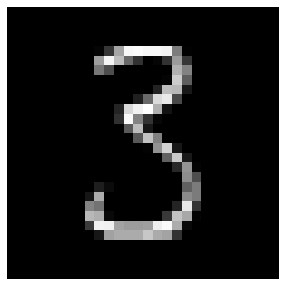

Real: 3 , Predicted:  3


In [104]:
img, label = data.next()
img = img[0, 0 ,:, :].numpy()
imgview(img)
print("Real:",int(label[0]),", Predicted: ", predict(img))